In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import bgreat

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
data = pd.read_csv("../data/example/data.csv",index_col=0)
meta = pd.read_csv("../data/example/meta.csv")

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
time,,,,,,,,,,,,,,,,,,,,,
0.0,0.094,0.096,0.099,0.096,0.101,0.098,0.091,0.093,0.095,0.096,...,0.103,0.105,0.101,0.114,0.111,0.098,0.097,0.099,0.107,0.096
0.5,0.094,0.095,0.097,0.097,0.100,0.097,0.091,0.092,0.094,0.094,...,0.092,0.091,0.093,0.099,0.095,0.092,0.091,0.092,0.091,0.089
1.0,0.095,0.096,0.098,0.099,0.103,0.101,0.093,0.094,0.096,0.095,...,0.093,0.092,0.094,0.100,0.096,0.093,0.093,0.094,0.091,0.090
1.5,0.095,0.097,0.098,0.100,0.105,0.102,0.093,0.094,0.097,0.096,...,0.095,0.094,0.095,0.101,0.098,0.095,0.095,0.096,0.092,0.092
2.0,0.096,0.098,0.099,0.101,0.107,0.104,0.095,0.095,0.098,0.097,...,0.096,0.095,0.096,0.102,0.099,0.096,0.096,0.097,0.093,0.093


In [6]:
meta.head()

,strain,Condition
0,parent,control
1,parent,control
2,parent,control
3,parent,control
4,parent,control


In [7]:
meta.shape

(47, 2)

In [8]:
data.shape

(97, 47)

In [9]:
assert data.shape[1] == meta.shape[0]

In [10]:
parent = 'parent'
control = 'control'
condition = 'stress'

meta['strain-regression'] = (meta.strain!=parent).astype(int)
meta['condition'] = (meta.Condition!=control).astype(int)
meta['interaction'] = meta['strain-regression']*meta.condition

(0.05, 0.7)

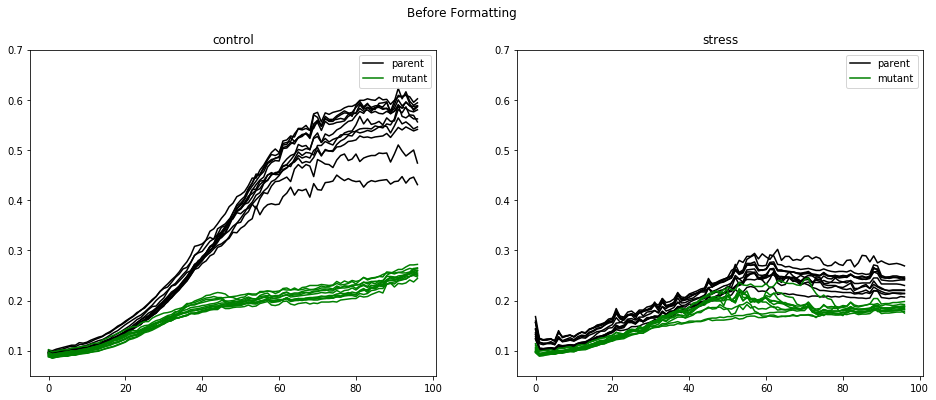

In [11]:
plt.figure(figsize=(16,6))
plt.suptitle("Before Formatting")

plt.subplot(121)
plt.title('control')
bgreat.plotSamples(data.values[:,np.where((meta.condition==0)& (meta.strain==parent))[0]],color='k',label='parent')
bgreat.plotSamples(data.values[:,np.where((meta.condition==0)& (meta.strain!=parent))[0]],color='g',label='mutant')
plt.legend(loc='best')
plt.ylim(0.05,.7)

plt.subplot(122)
plt.title('stress')
bgreat.plotSamples(data.values[:,np.where((meta.condition==1)& (meta.strain==parent))[0]],color='k',label='parent')
bgreat.plotSamples(data.values[:,np.where((meta.condition==1)& (meta.strain!=parent))[0]],color='g',label='mutant')
plt.legend(loc='best')
plt.ylim(0.05,.7)

## Formatting data

Required:
* time column should be a numeric type

Optional:
* log data
* subtract first time point
* remove early time points

In [12]:
# remove the first four time points

data = data.iloc[4:,:]

In [13]:
data.index = np.arange(0,data.shape[0]*.5,.5)

In [14]:
# log the data and subtract the first timepoint
data = np.log2(data)
data = data-data.iloc[0,:].values

(-0.5, 3.0)

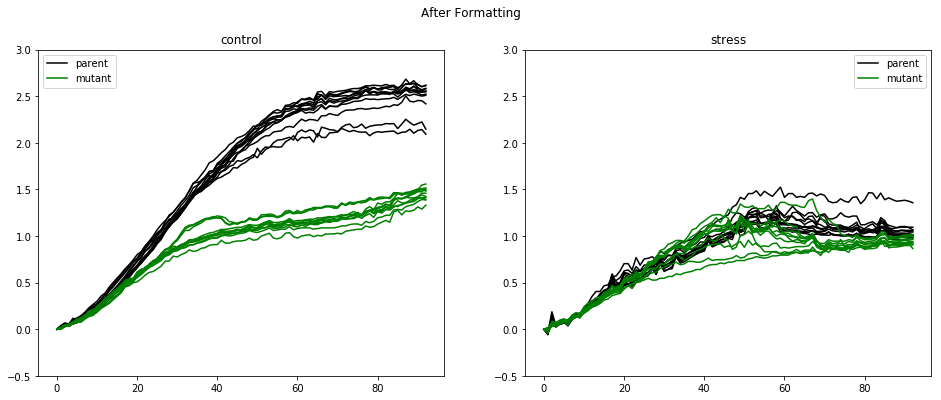

In [15]:
plt.figure(figsize=(16,6))
plt.suptitle("After Formatting")

plt.subplot(121)
plt.title('control')
bgreat.plotSamples(data.values[:,np.where((meta.condition==0)& (meta.strain==parent))[0]],color='k',label=parent)
bgreat.plotSamples(data.values[:,np.where((meta.condition==0)& (meta.strain!=parent))[0]],color='g',label='mutant')
plt.legend(loc='best')
plt.ylim(-.5,3.0)

plt.subplot(122)
plt.title('stress')
bgreat.plotSamples(data.values[:,np.where((meta.condition==1)& (meta.strain==parent))[0]],color='k',label='parent')
bgreat.plotSamples(data.values[:,np.where((meta.condition==1)& (meta.strain!=parent))[0]],color='g',label='mutant')
plt.legend(loc='best')
plt.ylim(-.5,3.0)

## B-GREAT globals

B-GREAT has a number of global variables that must be set before analysis. Setting these variables is done with the `setGlobals` method, by specifying the matching variable name with an '\_' prefix, e.g. `\_data` for the `data` variable. Briefly, the globals are:

* `data`: The data matrix used in this study
* `meta`: meta data associated with the data matrix, the numbers of columns in `data` should match the number of rows in `meta`
* `parent`: the name of the parent strain which will be tested against all other strains
* `control`: the control condition in the data, if applicable
* `condition`: the non-control condition to test, if applicable

In [16]:
import bgreat
bgreat.setGlobals(_data=data,_meta=meta)

bgreat.setGlobals(_parent=parent,_control=control)

## B-GREAT Analysis

### Analysis methods:

* `testMutantControl`: test mutant strain growth under the control condition
* `testMutantCondition`: test mutant strain growth under the non-control condition, conditioned on the control data

### Parameters:

* `numPerm`: the number of null permutations to perform for false discovery rate calculations
* `timeThin`: step size in selecting time-points for training the model

### Output:

* `actual`: actual Bayes factor (BF) score, representing the ratio of data likelihood when strain (or interaction) information is taken into account, e.g. $p(Y| H_a) / p(Y | H_0)$. Value is log of BF score.
* `permuted`: BF scores calculated when permuting the input in order to test the significance of the actual BF
* `FDR`: false discovery rate of the BF

In [42]:
bgreat.setGlobals(_data=data,_meta=meta,_parent=parent,_control=control,_condition=None)

In [43]:
mutants = ['mutant']
results = bgreat.testMutantControl(mutants,dims=['time','strain-regression'])

In [44]:
results

,actual,permuted,FDR
mutant,191.2383,"[0.221536116423, 0.0131564457399, 10.898267649...",0


In [38]:
bgreat.setGlobals(_data=data,_meta=meta,_parent=parent,_control=control,_condition=condition)

In [40]:
mutants = ['mutant']
results = bgreat.testMutantCondition(mutants,numPerm=1)

In [41]:
results

,actual,permuted,FDR
mutant,900.5643,[-1.40766790082e-05],0


### Further analysis 

#### Control

In [45]:
bgreat.condition = None
gp = bgreat.buildGP(bgreat.selectStrain('mutant'))

In [46]:
gp

GP_regression.,value,constraints,priors
mul.rbf.variance,1.25962383305,+ve,
mul.rbf.lengthscale,18.9318314579,+ve,
mul.rbf_1.variance,1.25962383304,+ve,
mul.rbf_1.lengthscale,1.80819049096,+ve,
Gaussian_noise.variance,0.00747296543678,+ve,


In [47]:
import GPy

In [55]:
# k = GPy.kern.RBF(1) + GPy.kern.RBF(1)*GPy.kern.ChangePointBasisFuncKernel(1,.5,active_dims=[1])
k = gp.kern.rbf + GPy.kern.RBF(1)*GPy.kern.ChangePointBasisFuncKernel(1,.5,active_dims=[1])
k

sum.,value,constraints,priors
rbf.variance,1.25962383305,+ve,
rbf.lengthscale,18.9318314579,+ve,
mul.rbf.variance,1.0,+ve,
mul.rbf.lengthscale,1.0,+ve,
mul.changepoint.variance,1.0,+ve,


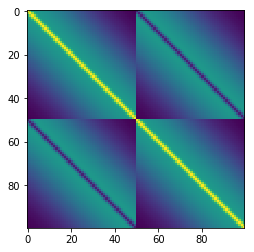

In [57]:
xpred = np.zeros((100,2))
xpred[:50,0] = np.linspace(data.index.min(),data.index.max())
xpred[50:,0] = np.linspace(data.index.min(),data.index.max())

xpred[50:,1] = 1

plt.imshow(k.K(xpred))

In [31]:
xpred = np.zeros((100,2))
xpred[:50,0] = np.linspace(data.index.min(),data.index.max())
xpred[50:,0] = np.linspace(data.index.min(),data.index.max())

xpred[50:,1] = 1

mu,cov = gp.predict(xpred,full_cov=True)
var = np.diag(cov)
mu = mu[:,0]

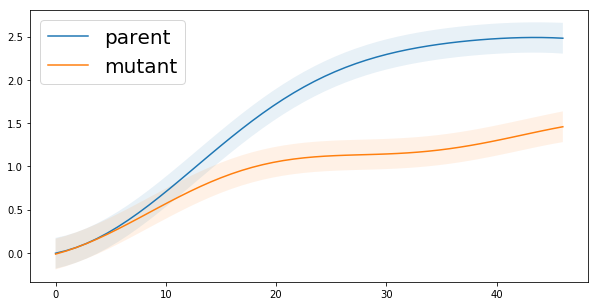

In [32]:
plt.figure(figsize=(10,5))

plt.plot(xpred[:50,0],mu[:50],label='parent');
plt.fill_between(xpred[:50,0],mu[:50]-2*np.sqrt(var[:50]),mu[:50]+2*np.sqrt(var[:50]),alpha=.1)

plt.plot(xpred[:50,0],mu[50:],label='mutant')
plt.fill_between(xpred[:50,0],mu[50:]-2*np.sqrt(var[50:]),mu[50:]+2*np.sqrt(var[50:]),alpha=.1)

plt.legend(fontsize=20)

In [33]:
op = np.zeros((50,100))
op[np.arange(50),np.arange(50)] = -1
op[np.arange(50),np.arange(50)+50] = 1

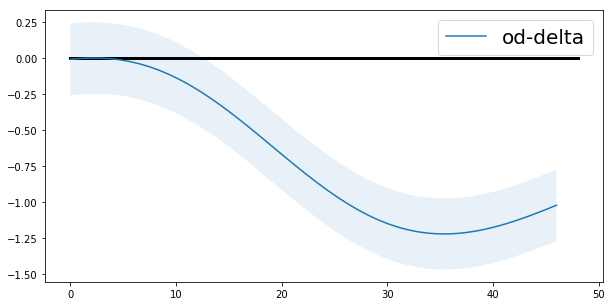

In [34]:
oddeltaMu = np.dot(op,mu)
oddeltaCov = np.dot(np.dot(op,cov),op.T)
oddeltaVar = np.diag(oddeltaCov)

plt.figure(figsize=(10,5))
plt.plot([0,48],[0,0],'k',lw=3)
plt.plot(xpred[:50,0],oddeltaMu,label='od-delta')
plt.fill_between(xpred[:50,0],oddeltaMu-2*np.sqrt(oddeltaVar),oddeltaMu+2*np.sqrt(oddeltaVar),alpha=.1)
plt.legend(fontsize=20)

####  Stress

In [23]:
bgreat.condition = 'stress'
gp = bgreat.buildGP(bgreat.selectStrain('mutant'),dims=['condition','interaction'])

In [24]:
gp

GP_regression.,value,constraints,priors
mul.rbf.variance,0.49425065344,+ve,
mul.rbf.lengthscale,13.1809941283,+ve,
mul.sum.rbf.variance,0.713858929783,+ve,
mul.sum.rbf.lengthscale,0.970113405899,+ve,
mul.sum.rbf_1.variance,0.969541012143,+ve,
mul.sum.rbf_1.lengthscale,0.586995244613,+ve,
mul.sum.rbf_2.variance,0.750351023183,+ve,
mul.sum.rbf_2.lengthscale,1.03309990961,+ve,
Gaussian_noise.variance,0.00782917761758,+ve,


In [31]:
xpred = np.zeros((200,4))
xpred[:,0] = np.tile(np.linspace(data.index.min(),data.index.max()),4)
xpred[100:,1] = 1
xpred[50:100,2] = 1
xpred[150:,2] = 1
xpred[150:,3] = 1

mu,cov = gp.predict(xpred,full_cov=True)
var = np.diag(cov)
mu = mu[:,0]

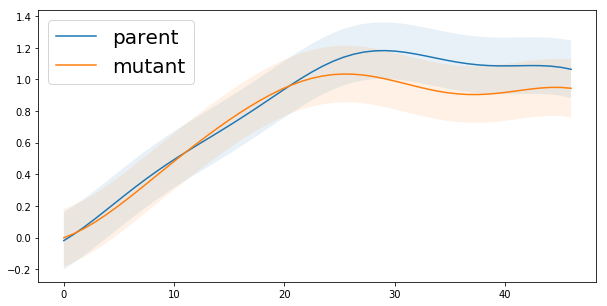

In [33]:
plt.figure(figsize=(10,5))

parentSlice = slice(50,100)
mutantSlice = slice(150,200)

plt.plot(xpred[parentSlice,0],mu[parentSlice],label='parent');
plt.fill_between(xpred[:50,0],mu[parentSlice]-2*np.sqrt(var[parentSlice]),mu[parentSlice]+2*np.sqrt(var[parentSlice]),alpha=.1)

plt.plot(xpred[:50,0],mu[mutantSlice],label='mutant')
plt.fill_between(xpred[mutantSlice,0],mu[mutantSlice]-2*np.sqrt(var[mutantSlice]),mu[mutantSlice]+2*np.sqrt(var[mutantSlice]),alpha=.1)

plt.legend(fontsize=20)

In [35]:
xpred = np.zeros((100,4))
xpred[:,0] = np.tile(np.linspace(data.index.min(),data.index.max()),2)
xpred[:,1] = 1
xpred[:,2] = 1
xpred[50:,3] = 1

mu,cov = gp.predict(xpred,full_cov=True)
var = np.diag(cov)
mu = mu[:,0]

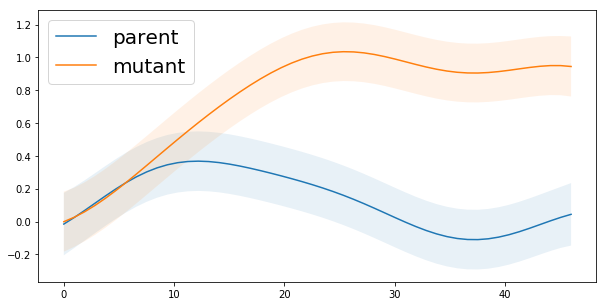

In [36]:
plt.figure(figsize=(10,5))

parentSlice = slice(0,50)
mutantSlice = slice(50,100)

plt.plot(xpred[parentSlice,0],mu[parentSlice],label='parent');
plt.fill_between(xpred[:50,0],mu[parentSlice]-2*np.sqrt(var[parentSlice]),mu[parentSlice]+2*np.sqrt(var[parentSlice]),alpha=.1)

plt.plot(xpred[:50,0],mu[mutantSlice],label='mutant')
plt.fill_between(xpred[mutantSlice,0],mu[mutantSlice]-2*np.sqrt(var[mutantSlice]),mu[mutantSlice]+2*np.sqrt(var[mutantSlice]),alpha=.1)

plt.legend(fontsize=20)

In [27]:
op = np.zeros((50,200))
op[np.arange(50),np.arange(50)+50] = -1
op[np.arange(50),np.arange(50)+150] = 1

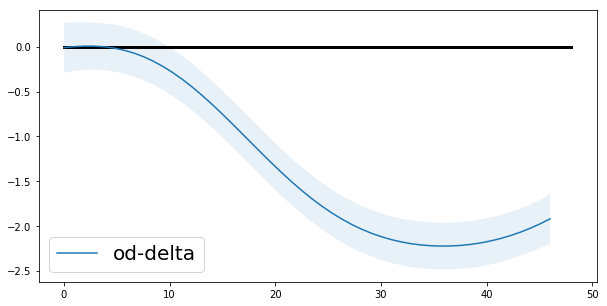

In [28]:
oddeltaMu = np.dot(op,mu)
oddeltaCov = np.dot(np.dot(op,cov),op.T)
oddeltaVar = np.diag(oddeltaCov)

plt.figure(figsize=(10,5))
plt.plot([0,48],[0,0],'k',lw=3)
plt.plot(xpred[:50,0],oddeltaMu,label='od-delta')
plt.fill_between(xpred[:50,0],oddeltaMu-2*np.sqrt(oddeltaVar),oddeltaMu+2*np.sqrt(oddeltaVar),alpha=.1)
plt.legend(fontsize=20)

plt.savefig("test.png")